# JNB1 - Build initial configuration for DFT simulations

Welcome to this Jupyter Notebook, where we will explore crystal units stored in the [Material Project](https://materialsproject.org/) database. 
Our objective is to generate initial configurations for performing Density Functional Theory (DFT) simulations. To achieve this, we will be utilizing the `Pymatgen` Python library.

This notebook represents the first step of the protocol discussed in the associated article (see the README.md file) as illustrated in the Figure 1 below.

The notebook is organized into sections based on the type of manipulations applied to the crystals. Here is an overview of the sections:

* [Get *Material Project* structures](#get_mp_structure)
* [Pure species system](#pure_species)
* [Supercells](#supercells)
* [Elastic strain](#elastic_strain)
* [Vacancies](#vacancies)
* [Substitution](#substitution)
* [Interstitial](#interstitial)
* [Slabs](#slabs)
* [Initial configuration for *ab initio* MD (DFTB) simulations](#ic_ab_initio)
    * [Amorphous bulk](#amorphous_bulk)
    * [Bulk at 500 K](#bulk_500)

Each section focuses on specific manipulations and explores different aspects of the crystals. Our main goal is to generate initial configurations that can be used in subsequent Jupyter Notebooks for performing DFT simulations.

<figure>
    <img src="assets/img/wf-JNB1.png" alt="JNB1 workflow">
    <figcaption><strong>Figure 1</strong>: Protocol workflow and part covered by this Jupyter Notebook highlighted in red.<figcaption>
<figure> 

## Load libraries

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ase.visualize import view
from numpy.random import PCG64, Generator
from pymatgen.analysis.defects.generators import (
    SubstitutionGenerator,
    VacancyGenerator,
    VoronoiInterstitialGenerator,
)
from pymatgen.analysis.elasticity.strain import Strain
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor

from tools import make_dir
from tools.interstitials import get_all_sites
from tools.mp import get_crystals, load_cifs

matget2ase = AseAtomsAdaptor()
plt.style.use("default")

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/ext/matproj.py:185: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


## Settings

In this section, we define the constants and generators that will be used throughout the notebook:

* `MAIN_DIR_JNB1`: The main folder where the results of this Jupyter Notebook will be stored.
* `CHEM_FORMULA`: The chemical formula of the SEI component.
* `SEED`: The seed number used for the random number generator.
* `pcg64`: The random number generator (PCG64).

These constants and generators play a crucial role in ensuring reproducibility and providing the necessary inputs for various computations and simulations in this notebook.

In [3]:
from tools.misc import MAIN_DIR_JNB1

CHEM_FORMULA = "LiF"
SEED = 2718

pcg64 = PCG64(seed=SEED)
rg = Generator(pcg64)

Making the output folder

In [4]:
make_dir(os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA))

## Get *Material Project* structures <a id='get_mp_structure'></a>

In [5]:
SUBDIR = "0-materialproject"
MP_CIF_DIR = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(MP_CIF_DIR)

Load possible structure from Material Project

In [6]:
info_df, systems, systems_ase = get_crystals("LiF")

N=3 crsital units found for the chemical formula `LiF`


In [7]:
info_df

,energy_per_atom,formation_energy_per_atom
mp-1138,-4.845146,-3.180409
mp-1185301,-4.838474,-3.173737
mp-1009009,-4.557603,-2.892867


Store the retrieved system and info

In [8]:
file_name = []
for i, (system, Ef_) in enumerate(zip(systems, info_df["formation_energy_per_atom"])):
    file_name.append(f"{i:d}-{CHEM_FORMULA}_{system.get_space_group_info()[0]}_{Ef_:1.2f}.cif".replace("/", ""))
    system.to(fmt="cif", filename=os.path.join(MP_CIF_DIR, file_name[-1]))

In addition we store the info as `json` file

In [9]:
info_df.loc[:, "file_name"] = file_name
info_df.set_index("file_name", inplace=True)
info_df.to_json(os.path.join(MP_CIF_DIR, "info.json"))

info_df

,energy_per_atom,formation_energy_per_atom
file_name,,
0-LiF_Fm-3m_-3.18.cif,-4.845146,-3.180409
1-LiF_P6_3mc_-3.17.cif,-4.838474,-3.173737
2-LiF_Pm-3m_-2.89.cif,-4.557603,-2.892867


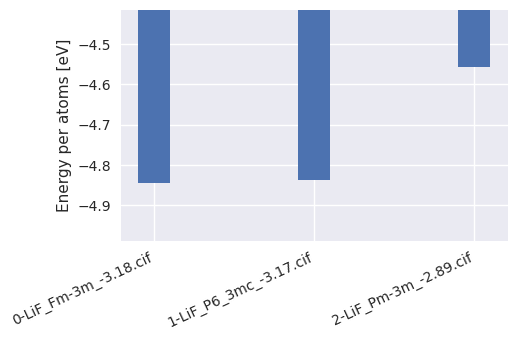

In [10]:
fig = plt.figure(figsize=[5, 3], dpi=100, facecolor="w")

with plt.style.context("seaborn"):
    ax = fig.add_subplot(111)
    Ef_np = info_df.energy_per_atom.values
    ax.bar(info_df.index.values, info_df.energy_per_atom.values, width=0.20)
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks([i for i in range(len(info_df.index))])
    ax.set_xticklabels(info_df.index.values, rotation=25, ha="right")
    delta_Ef = Ef_np.max() - Ef_np.min()
    mean_Ef = (Ef_np.max() + Ef_np.min()) / 2
    ax.set_ylim(mean_Ef - delta_Ef, mean_Ef + delta_Ef)
plt.show()

3D view of the system

In [11]:
view(systems_ase, viewer="ngl")

## Pure Species system <a id='pure_species'></a>

When modifying a system by adding or removing atoms for the purpose of ReaxFF training, it is beneficial to compare it with a stable system. For instance, instead of relying on the absolute energy of a Li atom added to a 2x2x2 supercell, it is more effective to use the energy difference relative to a stable crystal:

$\Delta E = E(Li_9F_8) - ( 8\times E(LiF) + 0.5 E(Li_2) )$

Therefore, in this section of the Jupyter Notebook, we will query the Materials Project database to obtain stable unit crystals that consist of only a single element.

In [12]:
SUBDIR = "0.1-pure_species"

Load structure

In [13]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Get unique elements in the system

In [14]:
elements = np.unique([i.name for i in systems[0][1].species])

Load possible structure from Material Project

In [15]:
info_df = []
systems = []
systems_ase = []

for el in elements:
    info_df_, systems_, systems_ase_ = get_crystals(el)
    indx = np.where(info_df_["energy_per_atom"] == info_df_["energy_per_atom"].min())[0][0]
    systems.append(systems_[indx])
    systems_ase.append(systems_ase_[indx])
    info_df__ = info_df_[info_df_["energy_per_atom"] == info_df_["energy_per_atom"].min()]
    temp_ = pd.DataFrame(columns=["element", "N"], index=info_df__.index)
    temp_["element"] = el
    temp_["N"] = len(systems_ase_[indx])
    info_df__ = info_df__.join(temp_)
    info_df.append(info_df__)
info_df = pd.concat(info_df)

N=5 crsital units found for the chemical formula `F`
N=8 crsital units found for the chemical formula `Li`


In [16]:
info_df

,energy_per_atom,formation_energy_per_atom,element,N
mp-561203,-1.911456,0.0,F,4
mp-1018134,-1.908923,0.0,Li,3


Store it

In [17]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
file_name = []
for i, (system, el, nel) in enumerate(zip(systems, info_df["element"], info_df["N"])):
    file_name.append(f"{i:d}-{el}_{system.get_space_group_info()[0].replace('/','')}_na{nel:d}.cif")
    system.to(fmt="cif", filename=os.path.join(out_dir, file_name[-1]))

In addition we store the info as `json` file

In [18]:
info_df.loc[:, "file_name"] = file_name
info_df.set_index("file_name", inplace=True)
info_df.to_json(os.path.join(out_dir, "info.json"))

info_df

,energy_per_atom,formation_energy_per_atom,element,N
file_name,,,,
0-F_C2c_na4.cif,-1.911456,0.0,F,4
1-Li_R-3m_na3.cif,-1.908923,0.0,Li,3


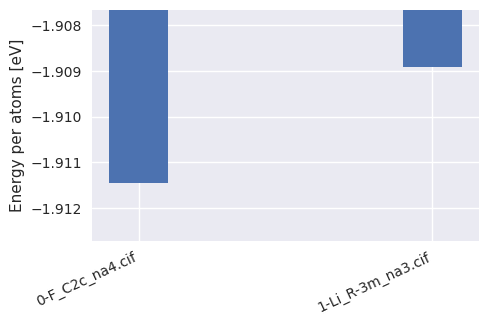

In [19]:
fig = plt.figure(figsize=[5, 3], dpi=100, facecolor="w")

with plt.style.context("seaborn"):
    ax = fig.add_subplot(111)
    Ef_np = info_df["energy_per_atom"].values
    ax.bar(file_name, Ef_np, width=0.20)
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks([i for i in range(len(Ef_np))])
    ax.set_xticklabels(file_name, rotation=25, ha="right")
    delta_Ef = Ef_np.max() - Ef_np.min()
    mean_Ef = (Ef_np.max() + Ef_np.min()) / 2
    ax.set_ylim(mean_Ef - delta_Ef, mean_Ef + delta_Ef)
plt.show()

In [20]:
view(systems_ase, viewer="ngl")

## Supercells <a id='supercells'></a>

In [21]:
SUBDIR = "1-supercell"
SUB_TRAINSET_ID = 1

Load structure

In [22]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [23]:
supercell_scale = [[2, 1, 1], [2, 2, 1], [2, 2, 2], [3, 2, 2], [3, 3, 2], [3, 3, 3]]
supercells = []
supercells_ase = []
supercell_info = {}

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell = syst_.copy()
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        supercells.append((filename, supercell.copy()))
        supercells_ase.append(matget2ase.get_atoms(supercell))
        # print(filename)
        n += 1

Store it

In [24]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, system in supercells:
    system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [25]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,unitcell_repetition
1.0-0-LiF_Fm-3m_-3.18_2x1x1.cif,2
1.1-0-LiF_Fm-3m_-3.18_2x2x1.cif,4
1.2-0-LiF_Fm-3m_-3.18_2x2x2.cif,8
1.3-0-LiF_Fm-3m_-3.18_3x2x2.cif,12
1.4-0-LiF_Fm-3m_-3.18_3x3x2.cif,18


In [26]:
v = view(supercells_ase, viewer="ngl")

## Elastic strain <a id='elastic_strain'></a>

In [27]:
SUBDIR = "2-strain"
SUB_TRAINSET_ID = 2

Load structure

In [28]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [29]:
supercell_scale = [(2, 2, 2)]
strain_amount = np.linspace(-0.125, 0.235, 13)
# defining the Green-Lagrange strain matrix
# in voigt notation [σ_xx, σ_yy, σ_zz, σ_yz, σ_xz, σ_xy]
strains = {
    "xx": np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    "xy": np.array([[0.0, 0.7, 0.0], [0.7, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    "xxyyzz": np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]),
}
new_systems = []
new_systems_ase = []
strain_info = {}

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale_x, scale_y, scale_z in supercell_scale:
        supercell = syst_.copy()
        supercell.make_supercell([scale_x, scale_y, scale_z])
        volume = supercell.volume
        for strain_type, strain_mtx in strains.items():
            for amount in strain_amount:
                filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{strain_type}_{amount:1.3f}.cif"
                obj_strain = Strain(strain_mtx * amount)
                strain_info[filename] = strain_mtx * amount
                defomation_mtx = obj_strain.get_deformation_matrix()
                obj_deformed = supercell.copy()
                obj_deformed = defomation_mtx.apply_to_structure(obj_deformed)
                new_systems.append((filename, obj_deformed.copy()))
                new_systems_ase.append(matget2ase.get_atoms(obj_deformed))
                n += 1

Store it

In [30]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)

for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [31]:
file_name = list(strain_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition", "strain_matrix"])
for file_name_ in file_name:
    info_df.loc[file_name_, "strain_matrix"] = strain_info[file_name_]
    info_df.loc[file_name_, "unitcell_repetition"] = np.prod(supercell_scale)
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,unitcell_repetition,strain_matrix
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif,8,"[[-0.125, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0..."
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif,8,"[[-0.095, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0..."
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif,8,"[[-0.065, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0..."
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif,8,"[[-0.035, -0.0, -0.0], [-0.0, -0.0, -0.0], [-0..."
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif,8,"[[-0.0050000000000000044, -0.0, -0.0], [-0.0, ..."


In [32]:
view(new_systems_ase, viewer="ngl")

## Vacancies <a id='vacancies'></a>

In [33]:
SUBDIR = "3-vacancies"
SUB_TRAINSET_ID = 3

Load structure

In [34]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Random removing Li atoms from in 2x2x2 supercell

In [35]:
supercell_scale = [[2, 2, 1]]
max_vacacy = 5
vacancy_info = {"site": {}, "element": {}, "unitcell_repetition": {}}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = syst_.copy()
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        temporary = supercell.copy()
        prev_vacancy_el = []
        prev_vacancy_site = []
        for nv in range(max_vacacy):
            primitive_elements = [e.species_string for e in supercell.get_primitive_structure().sites]
            vacancy_gen = VacancyGenerator().generate(temporary)
            temporary = []
            for v_site in list(vacancy_gen):
                site_el = v_site.site.species_string
                if site_el in primitive_elements:
                    primitive_elements.remove(site_el)
                elif len(primitive_elements) == 0:
                    break
                else:
                    continue
                filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_nv_{nv+1}.cif"
                vacancy_info["element"][filename] = prev_vacancy_el + [v_site.site.species_string]
                vacancy_info["site"][filename] = prev_vacancy_site + [v_site.site.coords]
                vacancy_info["unitcell_repetition"][filename] = np.prod(scale)
                obj_with_vacancy = v_site.defect_structure.copy()
                new_systems.append((filename, obj_with_vacancy.copy()))
                new_systems_ase.append(matget2ase.get_atoms(obj_with_vacancy))
                n += 1
                temporary.append(obj_with_vacancy.copy())
            # Store some data
            Nidx = len(temporary)
            keys = list(vacancy_info["element"].keys())
            idx = rg.choice(Nidx)
            temporary = temporary[idx]
            key = keys[-Nidx:][idx]
            prev_vacancy_el = vacancy_info["element"][key]
            prev_vacancy_site = vacancy_info["site"][key]

Store it

In [36]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [37]:
file_name = list(vacancy_info["element"].keys())
info_df = pd.DataFrame(index=file_name, columns=["vacancy_site", "vacancy_element", "unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = vacancy_info["unitcell_repetition"][file_name_]
    info_df.loc[file_name_, "vacancy_site"] = vacancy_info["site"][file_name_]
    info_df.loc[file_name_, "vacancy_element"] = vacancy_info["element"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,vacancy_site,vacancy_element,unitcell_repetition
3.0-0-LiF_Fm-3m_-3.18_nv_1.cif,"[[0.0, 0.0, 0.0]]",[Li],4
3.1-0-LiF_Fm-3m_-3.18_nv_1.cif,"[[1.6670525006439094, 1.1787841277992999, 2.88...",[F],4
3.2-0-LiF_Fm-3m_-3.18_nv_2.cif,"[[1.6670525006439094, 1.1787841277992999, 2.88...","[F, Li]",4
3.3-0-LiF_Fm-3m_-3.18_nv_2.cif,"[[1.6670525006439094, 1.1787841277992999, 2.88...","[F, F]",4
3.4-0-LiF_Fm-3m_-3.18_nv_3.cif,"[[1.6670525006439094, 1.1787841277992999, 2.88...","[F, Li, Li]",4


In [38]:
view(new_systems_ase, viewer="ngl")

## Substitution <a id='substitution'></a>

In [39]:
SUBDIR = "4-substitutions"
SUB_TRAINSET_ID = 4

Load structure

In [40]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Random substitue a Atom in 2x2x2 supercell

In [41]:
supercell_scale = [[2, 2, 1]]
max_substitution = 8
substitution_info = {"site": {}, "element": {}, "unitcell_repetition": {}}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = syst_.copy()
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        temporary = supercell.copy()
        prev_substitution_el = []
        prev_substitution_site = []
        for ns in range(max_substitution):
            substitution_gen = SubstitutionGenerator().generate(temporary, substitution={"Li": "F", "F": "Li"})
            filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_ns_{ns+1}.cif"
            sub_site = list(substitution_gen)
            n_sub_site = len(sub_site)
            idx = rg.choice(n_sub_site)
            sub_site = sub_site[idx]
            substitution_info["element"][filename] = prev_substitution_el + [sub_site.site.species_string]
            substitution_info["site"][filename] = prev_substitution_site + [sub_site.site.coords]
            substitution_info["unitcell_repetition"][filename] = np.prod(scale)
            obj_with_substitution = sub_site.defect_structure.copy()
            new_systems.append((filename, obj_with_substitution.copy()))
            new_systems_ase.append(matget2ase.get_atoms(obj_with_substitution))
            prev_substitution_el = substitution_info["element"][filename]
            prev_substitution_site = substitution_info["site"][filename]
            temporary = obj_with_substitution.copy()
            n += 1

Store it

In [42]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [43]:
file_name = list(substitution_info["element"].keys())
info_df = pd.DataFrame(index=file_name, columns=["substitution_site", "substitution_element", "unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = substitution_info["unitcell_repetition"][file_name_]
    info_df.loc[file_name_, "substitution_site"] = substitution_info["site"][file_name_]
    info_df.loc[file_name_, "substitution_element"] = substitution_info["element"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,substitution_site,substitution_element,unitcell_repetition
4.0-0-LiF_Fm-3m_-3.18_ns_1.cif,"[[0.0, 0.0, 0.0]]",[F],4
4.1-0-LiF_Fm-3m_-3.18_ns_2.cif,"[[0.0, 0.0, 0.0], [0.833526250321955, 2.357568...","[F, F]",4
4.2-0-LiF_Fm-3m_-3.18_ns_3.cif,"[[0.0, 0.0, 0.0], [0.833526250321955, 2.357568...","[F, F, Li]",4
4.3-0-LiF_Fm-3m_-3.18_ns_4.cif,"[[0.0, 0.0, 0.0], [0.833526250321955, 2.357568...","[F, F, Li, F]",4
4.4-0-LiF_Fm-3m_-3.18_ns_5.cif,"[[0.0, 0.0, 0.0], [0.833526250321955, 2.357568...","[F, F, Li, F, F]",4


In [44]:
v = view(new_systems_ase, viewer="ngl")

## Interstitial <a id='interstitial'></a>

In [45]:
SUBDIR = "5-interstitial"
SUB_TRAINSET_ID = 5

Load structure

In [46]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Random substitue a Atom in 2x2x2 supercell

In [47]:
pcg64 = PCG64(seed=SEED + SUB_TRAINSET_ID)
rg = Generator(pcg64)

supercell_scale = [[2, 2, 1]]
N_interstitial = np.arange(7)
interstitial_info = {"site": {}, "element": {}, "unitcell_repetition": {}}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        lattice = syst_.lattice
        supercell = syst_.copy()
        interstitial_gen = VoronoiInterstitialGenerator().generate(syst_, insert_species=["Li"])
        sites = list(interstitial_gen)
        r_sites = get_all_sites(sites, lattice, supercell=scale)
        rg.shuffle(r_sites, axis=0)
        supercell.make_supercell(scale)
        temporary = supercell.copy()
        prev_interstitial_el = []
        prev_interstitial_site = []
        for ni in N_interstitial:
            filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_ni_{ni}.cif"
            if ni == 0:
                interstitial_info["element"][filename] = []
                interstitial_info["site"][filename] = []
                interstitial_info["unitcell_repetition"][filename] = np.prod(scale)
            else:
                n_sites = len(r_sites)
                if n_sites > 0:
                    idx = rg.choice(n_sites)
                    intestitial_r = r_sites.pop(idx)
                    interstitial_info["element"][filename] = prev_interstitial_el + ["Li"]
                    interstitial_info["site"][filename] = prev_interstitial_site + [intestitial_r]
                    interstitial_info["unitcell_repetition"][filename] = np.prod(scale)
                    temporary.append("Li", intestitial_r, coords_are_cartesian=True)
                    temporary.set_charge(0.0)
                else:
                    continue
            new_systems.append((filename, temporary.copy()))
            new_systems_ase.append(matget2ase.get_atoms(temporary))
            prev_interstitial_el = interstitial_info["element"][filename]
            prev_interstitial_site = interstitial_info["site"][filename]
            n += 1

Store it

In [48]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [49]:
file_name = list(interstitial_info["element"].keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition", "interstitial_site", "interstitial_element"])
for file_name_ in file_name:
    info_df.loc[file_name_, "interstitial_site"] = interstitial_info["site"][file_name_]
    info_df.loc[file_name_, "interstitial_element"] = interstitial_info["element"][file_name_]
    info_df.loc[file_name_, "unitcell_repetition"] = interstitial_info["unitcell_repetition"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,unitcell_repetition,interstitial_site,interstitial_element
5.0-0-LiF_Fm-3m_-3.18_ni_0.cif,4,[],[]
5.1-0-LiF_Fm-3m_-3.18_ni_1.cif,4,"[[0.833526250321955, 0.5893920638996494, 1.443...",[Li]
5.2-0-LiF_Fm-3m_-3.18_ni_2.cif,4,"[[0.833526250321955, 0.5893920638996494, 1.443...","[Li, Li]"
5.3-0-LiF_Fm-3m_-3.18_ni_3.cif,4,"[[0.833526250321955, 0.5893920638996494, 1.443...","[Li, Li, Li]"
5.4-0-LiF_Fm-3m_-3.18_ni_4.cif,4,"[[0.833526250321955, 0.5893920638996494, 1.443...","[Li, Li, Li, Li]"


In [50]:
view(new_systems_ase, viewer="ngl")

## Slabs <a id='slabs'></a>

In [51]:
SUBDIR = "6-slabs"
SUB_TRAINSET_ID = 6

Load structure

In [52]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [53]:
supercell_scale = [1, 1, 1]
Nslabs = [1, 2, 3]
millers = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 1), (2, 1, 1)]
min_vacuum_size = 10  # [Ang]
slab_info = {"millers": {}, "slabs": {}}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for hkl in millers:
        for n_slabs in Nslabs:
            hkl_str = "".join([str(index) for index in hkl])
            filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{hkl_str}x{n_slabs}.cif"
            lc = syst_.lattice.parameters[3]
            vacuum_size = max([int(np.ceil(min_vacuum_size / lc) + 1), 2])
            slabgen = SlabGenerator(
                syst_,
                miller_index=hkl,
                min_slab_size=n_slabs,
                in_unit_planes=True,
                min_vacuum_size=vacuum_size,
                lll_reduce=False,
                center_slab=True,
            )
            slab = slabgen.get_slab()
            slab.make_supercell(supercell_scale)
            slab_info["millers"][filename] = hkl
            slab_info["slabs"][filename] = n_slabs
            new_systems.append((filename, slab.copy()))
            new_systems_ase.append(matget2ase.get_atoms(slab.copy()))
            n += 1

Store it

In [54]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [55]:
file_name = list(slab_info["millers"].keys())
info_df = pd.DataFrame(index=file_name, columns=["millers", "slabs"])
for file_name_ in file_name:
    info_df.loc[file_name_, "millers"] = slab_info["millers"][file_name_]
    info_df.loc[file_name_, "slabs"] = slab_info["slabs"][file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,millers,slabs
6.0-0-LiF_Fm-3m_-3.18_001x1.cif,"(0, 0, 1)",1
6.1-0-LiF_Fm-3m_-3.18_001x2.cif,"(0, 0, 1)",2
6.2-0-LiF_Fm-3m_-3.18_001x3.cif,"(0, 0, 1)",3
6.3-0-LiF_Fm-3m_-3.18_010x1.cif,"(0, 1, 0)",1
6.4-0-LiF_Fm-3m_-3.18_010x2.cif,"(0, 1, 0)",2


In [56]:
view(new_systems_ase, viewer="ngl")

## Initial configurationf for *ab intio* MD (DFTB) simulations <a id='ic_ab_initio'></a>

In this section, we initialize a 2x2x2 supercell, which will be used for *ab initio* Density Functional Tight Binding (DFTB) simulations. Frames will be extracted from this supercell and included in the database.

### Amorphous bulk  <a id='amorphous_bulk '></a>

In [57]:
SUBDIR = "7-amorphous"
SUB_TRAINSET_ID = 7

Load structure

In [58]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [59]:
supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = syst_.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell(scale)
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

Store it

In [60]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [61]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,unitcell_repetition
7.0-0-LiF_Fm-3m_-3.18_2x2x2.cif,8
7.0-1-LiF_P6_3mc_-3.17_2x2x2.cif,8
7.0-2-LiF_Pm-3m_-2.89_2x2x2.cif,8


In [62]:
view(new_systems_ase, viewer="ngl")

### Bulk at 300 K  <a id='bulk_300'></a>

In [63]:
SUBDIR = "8-bulk_300K"
SUB_TRAINSET_ID = 8

Load structure

In [64]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Random substitue a Atom in 2x2x2 supercell

In [65]:
supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = syst_.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

Store it

In [66]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [67]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,unitcell_repetition
8.0-0-LiF_Fm-3m_-3.18_2x2x2.cif,8
8.0-1-LiF_P6_3mc_-3.17_2x2x2.cif,8
8.0-2-LiF_Pm-3m_-2.89_2x2x2.cif,8


In [68]:
view(new_systems_ase, viewer="ngl")

### Bulk at 500 K  <a id='bulk_500'></a>

In [69]:
SUBDIR = "9-bulk_500K"
SUB_TRAINSET_ID = 9

Load structure

In [70]:
systems = load_cifs(MP_CIF_DIR)

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Random substitue a Atom in 2x2x2 supercell

In [71]:
supercell_scale = [[2, 2, 2]]
min_vacuum_size = 10  # [Ang]
supercell_info = {}
new_systems = []
new_systems_ase = []

for i, (name, syst_, syst_ase_) in enumerate(systems):
    n = 0
    for scale in supercell_scale:
        supercell = syst_.copy()
        filename = f"{SUB_TRAINSET_ID}.{n}-{i}-{name}_{scale[0]}x{scale[1]}x{scale[2]}.cif"
        supercell_info[filename] = scale[0] * scale[1] * scale[2]
        supercell.make_supercell([scale[0], scale[1], scale[2]])
        new_systems.append((filename, supercell.copy()))
        new_systems_ase.append(matget2ase.get_atoms(supercell))
        n += 1

Store it

In [72]:
out_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, SUBDIR)
make_dir(out_dir)
for filename, new_system in new_systems:
    new_system.to(fmt="cif", filename=os.path.join(out_dir, filename))

Save properties

In [73]:
file_name = list(supercell_info.keys())
info_df = pd.DataFrame(index=file_name, columns=["unitcell_repetition"])
for file_name_ in file_name:
    info_df.loc[file_name_, "unitcell_repetition"] = supercell_info[file_name_]
info_df.to_json(os.path.join(out_dir, "info.json"))
info_df.head()

,unitcell_repetition
9.0-0-LiF_Fm-3m_-3.18_2x2x2.cif,8
9.0-1-LiF_P6_3mc_-3.17_2x2x2.cif,8
9.0-2-LiF_Pm-3m_-2.89_2x2x2.cif,8


In [74]:
view(new_systems_ase, viewer="ngl")